In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from deap import base, creator, tools, algorithms
import random
from scipy.optimize import minimize


## Trading Strategy

  - **Purpose:** Generate trading signals based on alpha values and predefined thresholds.
  - **Logic:** 
    - Initializes with build and liquidate thresholds.
    - Generates signals to buy, sell, or hold based on the alpha values crossing the thresholds.
    - Positions are updated accordingly and recorded in the DataFrame.

In [2]:
class TradingStrategy:
    def __init__(self, build_threshold, liquidate_threshold):
        self.build_threshold = build_threshold
        self.liquidate_threshold = liquidate_threshold
        self.position = 0
    
    def generate_signals(self, df):
        df['position'] = 0
        for i in range(1, len(df)):
            alpha_prev = df.loc[i-1, 'alpha']
            alpha_curr = df.loc[i, 'alpha']
            
            if self.position == 0:
                if alpha_curr >= self.build_threshold:
                    self.position = 1
                elif alpha_curr <= -self.build_threshold:
                    self.position = -1
            elif self.position == 1:
                if alpha_curr <= self.liquidate_threshold:
                    self.position = 0
            elif self.position == -1:
                if alpha_curr >= -self.liquidate_threshold:
                    self.position = 0
            
            df.loc[i, 'position'] = self.position
        
        df.loc[len(df)-1, 'position'] = 0
        return df

## Backtesting Engine

  - **Purpose:** Backtest the trading strategy and calculate the PnL.
  - **Logic:**
    - Initializes with a DataFrame containing price and alpha values.
    - Runs the backtest, calculates daily returns, and computes cumulative returns (PnL in percentage terms).
    - Provides functionality to plot the PnL graph

In [3]:
class BacktestingEngine:
    def __init__(self, df):
        self.df = df
    
    def backtest(self, strategy):
        df = strategy.generate_signals(self.df)
        df['returns'] = df['price'].pct_change().shift(-1)
        df['returns'].fillna(0, inplace=True)  # Handle NaN values
        df['strategy_returns'] = df['position'].shift(1) * df['returns']
        df['strategy_returns'].fillna(0, inplace=True)  # Handle NaN values
        df['cumulative_returns'] = (df['strategy_returns'] + 1).cumprod() - 1
        pnl = df['cumulative_returns'].iloc[-1]
        return df, pnl
    
    def plot_pnl(self, df):
        plt.figure(figsize=(10, 6))
        plt.plot(df.index, df['cumulative_returns'])
        plt.xlabel("Index")
        plt.ylabel("PnL")
        plt.title("PnL graph")
        plt.show()

## Task 1 and 2 demonstration
- Load csv file
- Create trading strategy with static thresholds 0.6 and 0.2
    - **Current strategy total PnL:** 0.22
- Perform backtesting and get the modified dataframe and the total PnL
- Plot PnL with time using cumulative returns from the modified dataframe

In [4]:
df = pd.read_csv('asset_1.csv')

Final PnL: 0.22


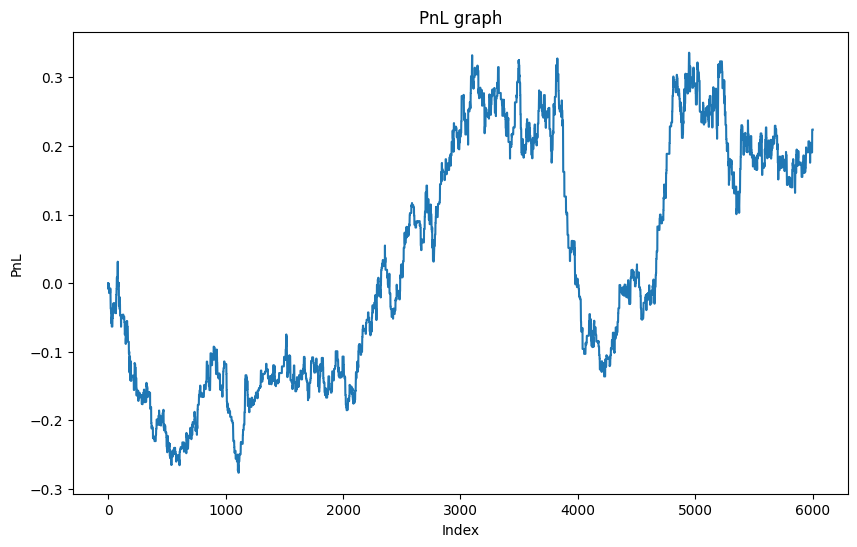

In [5]:
trading_strategy = TradingStrategy(0.6, 0.2)
backtesting_engine = BacktestingEngine(df)
modified_df, pnl = backtesting_engine.backtest(trading_strategy)
# Print the final PnL value
print(f"Final PnL: {pnl:.2f}")

# Plot the PnL graph
backtesting_engine.plot_pnl(modified_df)

In [8]:
print(modified_df.head())

   serial_num         price     alpha  position   returns  strategy_returns  \
0           0  18105.300781  0.000000         0  0.016220          0.000000   
1           1  18398.960605 -0.630291        -1 -0.010545         -0.000000   
2           2  18204.939538 -0.123420         0  0.007384         -0.007384   
3           3  18339.357782 -0.240239         0  0.013017          0.000000   
4           4  18578.084798 -0.612625        -1  0.007134          0.000000   

   cumulative_returns  
0            0.000000  
1            0.000000  
2           -0.007384  
3           -0.007384  
4           -0.007384  


## Genetic Algorithm Optimizer
- **Purpose:** Optimize the build and liquidate thresholds using a genetic algorithm.
- **Logic:**
    - Initializes with the DataFrame and GA parameters.
    - Sets up the DEAP toolbox for the genetic algorithm.
    - Evaluates individuals by running the backtest and returning the PnL.
    - Runs the genetic algorithm to find the optimal thresholds.
    - Returns the best thresholds found by the GA.
 - **Algorithm:**
     - The Genetic algorithm improves potential solutions by using the concept of natural selection
     - The best solutions are more likely to reproduce and create the next generation
     - The three main operations of the algorithm are:
         - **Selection:** Chooses the fittest individuals to reproduct
         - **Crossover:** Creates new solutions(offsprings) from parent solutions
         - **Mutation:** Introduces random changes to offspring to maintain genetic diversity
     - Constraints are handled by penalizing invalid solutions in the evaluate method
     - This constraint ensures that the trading strategy follows the convention of buying at higher alpha values and selling or shorting at lower alpha values, aligning with common practices in trading strategies based on alpha signals.
     

In [9]:
class GAOptimizer:
    def __init__(self, df, ngen=40, cxpb=0.5, mutpb=0.2, pop_size=50):
        self.df = df
        self.ngen = ngen
        self.cxpb = cxpb
        self.mutpb = mutpb
        self.pop_size = pop_size
        
        # Genetic Algorithm Setup
        creator.create("FitnessMax", base.Fitness, weights=(1.0,))
        creator.create("Individual", list, fitness=creator.FitnessMax)

        self.toolbox = base.Toolbox()
        self.toolbox.register("attr_float", random.uniform, 0.1, 1.0)
        self.toolbox.register("individual", tools.initCycle, creator.Individual, (self.toolbox.attr_float, self.toolbox.attr_float), n=1)
        self.toolbox.register("population", tools.initRepeat, list, self.toolbox.individual)
        self.toolbox.register("mate", tools.cxBlend, alpha=0.5)
        self.toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.1, indpb=0.2)
        self.toolbox.register("select", tools.selTournament, tournsize=3)
        self.toolbox.register("evaluate", self.evaluate)

    def evaluate(self, individual):
        build_threshold, liquidate_threshold = individual
        if build_threshold <= liquidate_threshold:
            return -1e6,  # Penalize invalid thresholds
        strategy = TradingStrategy(build_threshold, liquidate_threshold)
        backtesting_engine = BacktestingEngine(self.df)
        _, pnl = backtesting_engine.backtest(strategy)
        return pnl,

    def optimize(self):
        random.seed(42)
        population = self.toolbox.population(n=self.pop_size)

        hof = tools.HallOfFame(1)
        stats = tools.Statistics(lambda ind: ind.fitness.values)
        stats.register("avg", np.mean)
        stats.register("std", np.std)
        stats.register("min", np.min)
        stats.register("max", np.max)

        algorithms.eaSimple(population, self.toolbox, self.cxpb, self.mutpb, self.ngen, stats, halloffame=hof, verbose=True)

        return hof[0]


## Finding optimal thresholds
- Used genetic algorithm optimizer to find the optimmal thresholds under the condition that build threshold should be greater than liquidate threshold
- Obtained and plotted the optimal pnl corresponding to the optimal static threshold strategy
    - **Optimal strategy build threshold:** 0.856
    - **Optimal strategy liquidate threshold:** 0.530
    - **Optimal strategy total PnL:** 0.87

gen	nevals	avg    	std   	min   	max     
0  	50    	-340000	473709	-1e+06	0.729295
1  	33    	-99999.6	300000	-1e+06	0.662847
2  	30    	-59999.5	237487	-1e+06	0.754703
3  	32    	-19999.5	140000	-1e+06	0.800086
4  	32    	0.651125	0.143892	0.190215	0.806519
5  	29    	-19999.3	140000  	-1e+06  	0.837664
6  	23    	0.771004	0.071045	0.442347	0.837664
7  	24    	0.79076 	0.0604681	0.453561	0.873312
8  	20    	0.81181 	0.0403409	0.674712	0.873312
9  	34    	0.804237	0.0843322	0.360624	0.89125 
10 	28    	0.809887	0.0946286	0.398466	0.89125 
11 	21    	0.848893	0.0699438	0.415288	0.89125 
12 	31    	0.843507	0.100238 	0.263762	0.89125 
13 	38    	0.867841	0.0318787	0.647959	0.89125 
14 	28    	0.864978	0.0327964	0.690898	0.873312
15 	27    	0.838484	0.110998 	0.249989	0.873312
16 	25    	0.848511	0.0824591	0.429738	0.873312
17 	25    	0.856049	0.0806923	0.411869	0.89125 
18 	33    	0.856622	0.0770513	0.355309	0.873312
19 	22    	0.857627	0.0936212	0.213774	0.873312
20 	31    	0.863638	0.

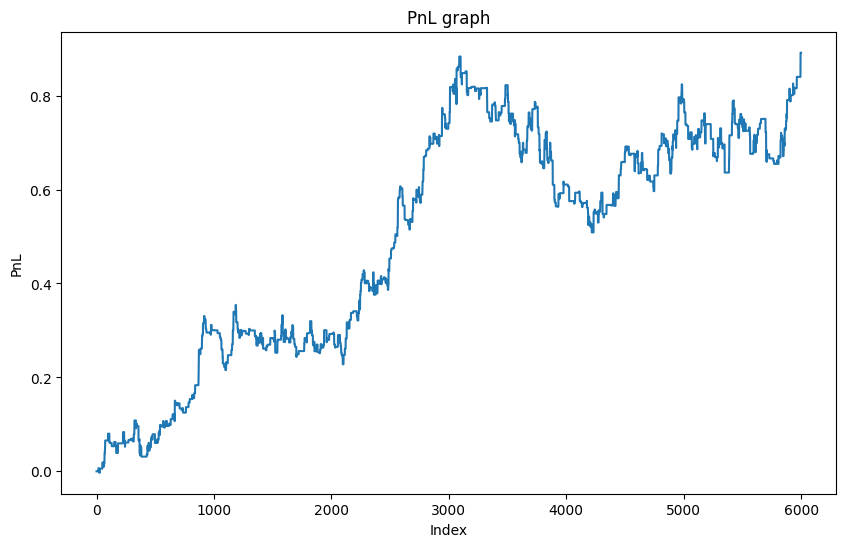

In [80]:
# Initialize the optimizer
optimizer = GAOptimizer(df)

# Run the optimization
best_individual = optimizer.optimize()
best_build_threshold, best_liquidate_threshold = best_individual
print(f"Optimal Build Threshold: {best_build_threshold}")
print(f"Optimal Liquidate Threshold: {best_liquidate_threshold}")

# Run backtest with optimal thresholds and plot PnL
optimal_strategy = TradingStrategy(best_build_threshold, best_liquidate_threshold)
backtesting_engine = BacktestingEngine(df)
optimal_df, optimal_pnl = backtesting_engine.backtest(optimal_strategy)

backtesting_engine.plot_pnl(optimal_df)

Final PnL: 0.87


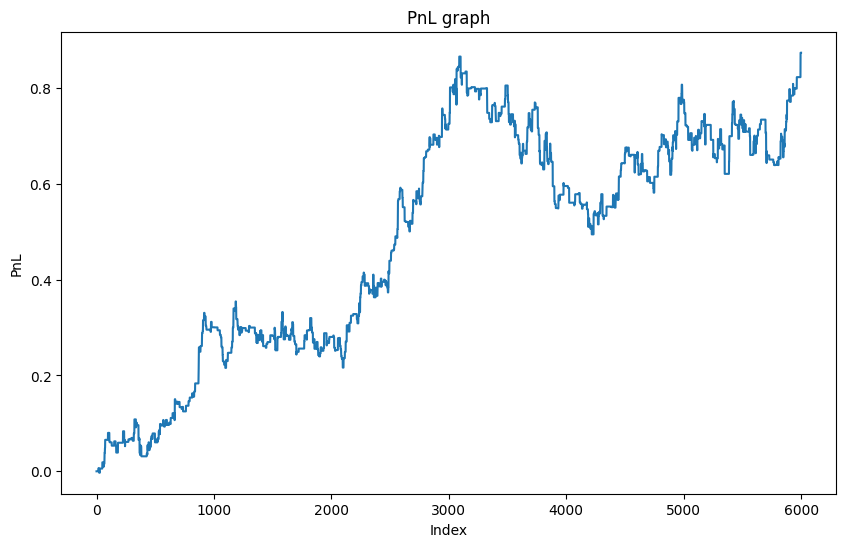

In [10]:
trading_strategy = TradingStrategy(0.856, 0.53)
backtesting_engine = BacktestingEngine(df)
modified_df, pnl = backtesting_engine.backtest(trading_strategy)
# Print the final PnL value
print(f"Final PnL: {pnl:.2f}")

# Plot the PnL graph
backtesting_engine.plot_pnl(modified_df)

## Powell Optimizer
- **Purpose:** Optimize the build and liquidate thresholds using Powell's Optimization method
- **Logic:**
    - Initializes with the DataFrame
    - Evaluates individuals by running the backtest and returning the negative PnL (to minimize).
    - Utilizes Powell's method to iteratively adjust thresholds and minimize the negative PnL.
    - Returns the optimal thresholds found by Powell's method.
 - **Algorithm:**
     - Powell's method is a derivative-free optimization algorithm.
     - It iteratively adjusts parameters to minimize a given objective function.
     - In this case, the objective function represents the trading strategy's performance (negative PnL).
     - The optimization process continues until convergence, providing optimal thresholds that aim to maximize trading performance.
     - It cannot handle constraints
     

In [2]:
class PowellOptimizer:
    def __init__(self, df):
        self.df = df

    def evaluate(self, thresholds):
        build_threshold, liquidate_threshold = thresholds
        strategy = TradingStrategy(build_threshold, liquidate_threshold)
        backtesting_engine = BacktestingEngine(self.df)
        _, pnl = backtesting_engine.backtest(strategy)
        return -pnl  # Minimize negative PnL

    def optimize(self):
        initial_guess = [0.5, 0.2]  # Initial guess for thresholds
        result = minimize(self.evaluate, initial_guess, method='powell')
        optimal_thresholds = result.x
        return optimal_thresholds

In [8]:
powell_optimizer = PowellOptimizer(df)
optimal_thresholds = powell_optimizer.optimize()
print("Optimal Thresholds (Build, Liquidate):", optimal_thresholds)

Optimal Thresholds (Build, Liquidate): [0.69156056 0.38672887]


Final PnL: 0.93


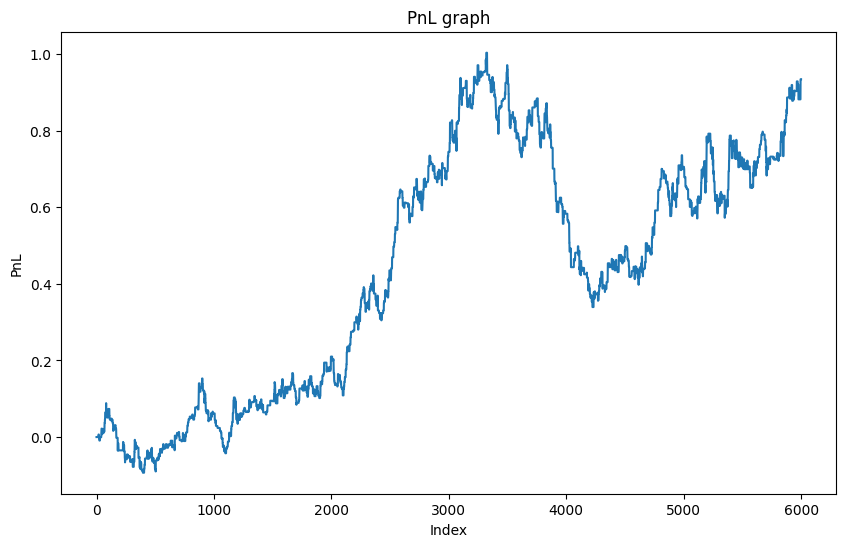

In [6]:
trading_strategy = TradingStrategy(0.692, 0.387)
backtesting_engine = BacktestingEngine(df)
modified_df, pnl = backtesting_engine.backtest(trading_strategy)
# Print the final PnL value
print(f"Final PnL: {pnl:.2f}")

# Plot the PnL graph
backtesting_engine.plot_pnl(modified_df)